In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


num_cycles = 15000
num_samples = num_cycles
np.random.seed(42)

driving_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
charging_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
temperatures = np.random.normal(loc=25, scale=5, size=num_samples)

DoD = np.random.uniform(50, 100, size=num_samples) ### Depth of discharge (how much battery has been used)

trip_length = np.random.normal(loc=50, scale=20, size=num_samples)
cycles = np.arange(num_samples)

SoH = np.zeros(num_samples)
FCR = np.zeros(num_samples)

SoH[0] = 100.0
base_range = 500

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]
temp_effect = lambda T: 1 + 0.005*(T-25)
dod_effect = lambda d: 1 + 0.002*(d-80)
trip_effect = lambda t: 1 + 0.001*(t-50)
base_degradation_rate = 0.0025

knee_threshold = 70.0  # The SoH % where degradation starts to accelerate
knee_severity = 0.03


for i in range(1, num_samples):
    dp = driving_patterns[i]
    cp = charging_patterns[i]
    temp = temperatures[i]
    dod = DoD[i]
    trip = trip_length[i]
    
    degradation_step = (base_degradation_rate * k_base[dp] * charging_effect[cp] * dod_effect(dod) * trip_effect(trip) * temp_effect(temp))
    
    if SoH[i-1] < knee_threshold:
        acceleration_factor = 1 + (knee_threshold - SoH[i-1]) * knee_severity
        degradation_step *= acceleration_factor
    
    # 3. Add Stochastic Noise (Real-world sensor/chemical jitter)
    noise = np.random.normal(0, 0.00045) 
    
    SoH[i] = SoH[i-1] - degradation_step + noise
    SoH[i] = np.clip(SoH[i], 20, 100)
    
    # 4. FCR with Sensor Noise
    fcr_noise = np.random.normal(0, 1.5) # +/- 1.5km variance in range estimation
    FCR[i] = (base_range * (SoH[i]/100) * (1 - 0.02*dp) * temp_effect(temp) * (1 - 0.01*cp)) + fcr_noise


FCR[0] = base_range * (SoH[0]/100) * (1 - 0.02*driving_patterns[0]) * temp_effect(temperatures[0]) * (1 - 0.01*charging_patterns[0])


df = pd.DataFrame({
    'cycle': cycles,
    'temperature': temperatures,
    'driving_pattern': driving_patterns,
    'charging_pattern': charging_patterns,
    'DoD': DoD,
    'trip_length_km': trip_length,
    'SoH': SoH,
    'FCR': FCR
})

df.to_csv('new_data.csv', index=False)

print("Data Generation Complete")
print(df.head(10))

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('new_data.csv')

base_range = 500
R0 = 0.05
alpha = 0.5
knee_threshold = 70.0
knee_severity = 0.03
base_degradation_rate = 0.0025 

def temp_factor(T):
    return 1 + 0.005*(T-25)

def dod_factor(DoD):
    return 1 + 0.002*(DoD-80)

def trip_factor(trip):
    return 1 + 0.001*(trip-50)

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]

SoH_phys = np.zeros(len(df))
FCR_phys = np.zeros(len(df))
R_int = np.zeros(len(df))

SoH_phys[0] = 100.0

for i in range(1, len(df)):
    row = df.iloc[i]
    dp = int(row['driving_pattern'])
    cp = int(row['charging_pattern'])
    temp = row['temperature']
    dod = row['DoD']
    trip = row['trip_length_km']
    
    phys_deg_step = (base_degradation_rate * k_base[dp] * charging_effect[cp] * dod_factor(dod) * trip_factor(trip) * temp_factor(temp))
  
    if SoH_phys[i-1] < knee_threshold:
        acceleration = 1 + (knee_threshold - SoH_phys[i-1]) * knee_severity
        phys_deg_step *= acceleration

    SoH_phys[i] = max(20, SoH_phys[i-1] - phys_deg_step)
    
    R_int[i] = R0 * (1 + alpha * (100 - SoH_phys[i]) / 100)
    
    FCR_phys[i] = base_range * (SoH_phys[i]/100) * (1 - 0.02*dp) * temp_factor(temp) * (1 - 0.01*cp)


df['SoH_phys'] = SoH_phys
df['FCR_phys'] = FCR_phys
df['R_int'] = R_int

print("\n--- Prep Complete ---")
print(df.head(10))

In [ ]:
from torch.utils.data import Subset

feature_cols = ['cycle','temperature','driving_pattern','charging_pattern',
'DoD','trip_length_km']

target_cols = ['SoH','FCR']

physics_constraint_cols = ['SoH_phys', 'FCR_phys']


seq_len = 10
y_true_original = df[target_cols].values[seq_len:]
cycles_unscaled_for_reporting = df['cycle'].values[seq_len:]


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])

df[target_cols] = target_scaler.fit_transform(df[target_cols].values)

df[physics_constraint_cols] = target_scaler.transform(df[physics_constraint_cols].values)


class EVBatteryDataset(Dataset):

    def __init__(self, df, seq_len=10):
        self.seq_len = seq_len
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_cols].values.astype(np.float32)
        self.physics = df[physics_constraint_cols].values.astype(np.float32)
  
    def __len__(self):
        return len(self.features) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.features[idx:idx+self.seq_len]
        y = self.targets[idx+self.seq_len]
        phys = self.physics[idx+self.seq_len] 
        return torch.tensor(x), torch.tensor(y), torch.tensor(phys)

dataset = EVBatteryDataset(df, seq_len=seq_len)


class HybridLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=1, output_size=2):
        super(HybridLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


def physics_loss(y_pred, y_true, phys, prev_y_pred=None, lambda_mono=0.5):
    mse = nn.MSELoss()(y_pred, y_true)
    fcr_penalty = torch.mean(torch.clamp(y_pred[:, 1] - phys[:, 1], min=0))
    
    mono_penalty = 0
    if prev_y_pred is not None:
        # Prevents SoH from increasing
        diff = y_pred[:, 0] - prev_y_pred[:, 0]
        mono_penalty = torch.mean(torch.clamp(diff, min=0))
        
    return mse + (0.1 * fcr_penalty) + (lambda_mono * mono_penalty)

train_size = int(0.8 * len(dataset))
train_loader = DataLoader(Subset(dataset, range(train_size)), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(dataset, range(train_size, len(dataset))), batch_size=32, shuffle=False)

model = HybridLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    


print(f"Model input features: {len(feature_cols)} {feature_cols}")

In [14]:
device = 'cuda'
model.to(device)
print(f"Training on device: {device}")


num_epochs = 180

for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    for x, y, phys in train_loader:
        x = x.float().to(device)
        y = y.float().to(device)
        phys = phys.float().to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = physics_loss(y_pred, y, phys)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if (epoch+1) % 15 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")       


print("Model Training Complete")

Training on device: cuda
Epoch 15/180, Loss: 0.0027
Epoch 30/180, Loss: 0.0026
Epoch 45/180, Loss: 0.0026
Epoch 60/180, Loss: 0.0026
Epoch 75/180, Loss: 0.0026
Epoch 90/180, Loss: 0.0026
Epoch 105/180, Loss: 0.0026
Epoch 120/180, Loss: 0.0025
Epoch 135/180, Loss: 0.0025
Epoch 150/180, Loss: 0.0023
Epoch 165/180, Loss: 0.0021
Epoch 180/180, Loss: 0.0019
Model Training Complete


In [15]:
model.eval()
pred_results = []

features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)


with torch.no_grad():

    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = model(x_seq)
        pred_results.append(y_pred[0].cpu().numpy())

pred_results = np.array(pred_results)
pred_unscaled = target_scaler.inverse_transform(pred_results)


cycles = cycles_unscaled_for_reporting
pred_df = pd.DataFrame({
    'cycle': cycles,
    'SoH_pred': pred_unscaled[:,0],
    'FCR_pred': pred_unscaled[:,1]
})

target_soh = [100, 90, 80, 70, 60]
table = []
for soh in target_soh:
    row = pred_df.iloc[(pred_df['SoH_pred'] - soh).abs().argsort()[:1]]
    table.append({
        'Target SoH (%)': soh,
        'Predicted SoH (%)': round(float(row['SoH_pred']),2),
        'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
        'Cycle': int(row['cycle'])
    })

results_df = pd.DataFrame(table)
print("\nPredicted Range Table")
print(results_df)


Predicted Range Table
   Target SoH (%)  Predicted SoH (%)  Predicted Full-Charge Range (km)  Cycle
0             100             100.00                            472.56    185
1              90              90.00                            432.13   4102
2              80              80.00                            384.32   8084
3              70              70.00                            342.34  12203
4              60              63.77                            314.73  14902


C:\Users\Jai\AppData\Local\Temp\ipykernel_5780\2129386855.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH (%)': round(float(row['SoH_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_5780\2129386855.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_5780\2129386855.py:33: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  'Cycle': int(row['cycle'])
C:\Users\Jai\AppData\Local\Temp\ipykernel_5780\2129386855.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH

In [16]:
### HYBRID PHYSICS - LSTM PREDICTIONS


from sklearn.metrics import mean_absolute_error, r2_score

mae_soh_hybrid = mean_absolute_error(y_true_original[:, 0], pred_unscaled[:, 0])
mae_fcr_hybrid = mean_absolute_error(y_true_original[:, 1], pred_unscaled[:, 1])
r2_soh_hybrid = r2_score(y_true_original[:, 0], pred_unscaled[:, 0])
r2_fcr_hybrid = r2_score(y_true_original[:, 1], pred_unscaled[:, 1])

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'R2'],  
    'SoH': [mae_soh_hybrid, r2_soh_hybrid],
    'FCR': [mae_fcr_hybrid, r2_fcr_hybrid]
})

print("\nHybrid - Metrics")
print(metrics_df)


Hybrid - Metrics
  Metric       SoH        FCR
0    MAE  0.678732  10.210389
1     R2  0.991748   0.938538


In [17]:
import shap

X_sample = df[feature_cols].iloc[seq_len:110].values.astype(np.float32)


def model_predict_last_step(input_np):

    seq_input = np.repeat(input_np[:, np.newaxis, :], seq_len, axis=1)
    input_tensor = torch.tensor(seq_input, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(input_tensor)
    return out[:, 0].cpu().numpy()

explainer = shap.KernelExplainer(model_predict_last_step, X_sample)
shap_values = explainer.shap_values(X_sample)


feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance (mean abs SHAP)': feature_importance
}).sort_values(by='Importance (mean abs SHAP)', ascending=False)


print("\nSHAP Feature Importance")
print(shap_df)

  0%|          | 0/100 [00:00<?, ?it/s]


SHAP Feature Importance
            Feature  Importance (mean abs SHAP)
3  charging_pattern                    0.004787
2   driving_pattern                    0.002455
4               DoD                    0.002423
5    trip_length_km                    0.001785
0             cycle                    0.001606
1       temperature                    0.001082


In [18]:
pred_df['SoH_diff'] = pred_df['SoH_pred'].diff().fillna(0)
pred_df['Degradation_perc_per_cycle'] = -pred_df['SoH_diff']

avg_degradation = pred_df['Degradation_perc_per_cycle'].mean()

degradation_df = pd.DataFrame({
    'Metric': ['Average Degradation per cycle (%)'],
    'Value': [avg_degradation]
})

print("\n--- Degradation Analysis ---")
print(degradation_df)

top_degradation_df = pred_df[['cycle','SoH_pred','Degradation_perc_per_cycle']].sort_values(
    by='Degradation_perc_per_cycle', ascending=False
).head(10)

print("\nTop 10 cycles with highest degradation:")
print(top_degradation_df)


--- Degradation Analysis ---
                              Metric     Value
0  Average Degradation per cycle (%)  0.002352

Top 10 cycles with highest degradation:
       cycle   SoH_pred  Degradation_perc_per_cycle
12624  12634  68.896919                    3.079025
14978  14988  65.081558                    2.549538
14039  14049  66.129166                    2.491486
14932  14942  65.192398                    2.442993
14355  14365  65.661957                    2.419327
12900  12910  69.573509                    2.267151
14975  14985  64.100922                    2.218216
13150  13160  67.177383                    2.128571
13098  13108  68.359367                    2.102829
13292  13302  67.942543                    2.052170


In [19]:
### PHYSICS ONLY PREDICTIONS

from sklearn.metrics import mean_absolute_error


soh_phys = df['SoH_phys'].values[seq_len:]
fcr_phys = df['FCR_phys'].values[seq_len:]


soh_true = y_true_original[:, 0]
fcr_true = y_true_original[:, 1]


mae_soh_phys = mean_absolute_error(soh_true, soh_phys)
mae_fcr_phys = mean_absolute_error(fcr_true, fcr_phys)

print(f"Physics-only Model - MAE SoH: {mae_soh_phys:.3f}, MAE FCR: {mae_fcr_phys:.3f}")


Physics-only Model - MAE SoH: 80.679, MAE FCR: 393.852


In [21]:
### ML ONLY PREDICTIONS


class PureLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, output_size=2):
        super(PureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


pure_model = PureLSTM().to(device)
optimizer = torch.optim.Adam(pure_model.parameters(), lr=0.002)
criterion = nn.MSELoss()

for epoch in range(100):
    pure_model.train()
    total_loss = 0
    for x, y, phys in train_loader:
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        y_pred = pure_model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Pure LSTM Loss: {total_loss/len(train_loader):.4f}")

pure_model.eval()
pred_results_pure = []

with torch.no_grad():
    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = pure_model(x_seq)
        pred_results_pure.append(y_pred[0].cpu().numpy())

pred_results_pure = np.array(pred_results_pure)
pred_unscaled_pure = target_scaler.inverse_transform(pred_results_pure)

mae_soh_pure = mean_absolute_error(soh_true, pred_unscaled_pure[:, 0])
mae_fcr_pure = mean_absolute_error(fcr_true, pred_unscaled_pure[:, 1])

print(f"Pure LSTM - MAE SoH: {mae_soh_pure:.3f}, MAE FCR: {mae_fcr_pure:.3f}")        

Epoch 20/100, Pure LSTM Loss: 0.0013
Epoch 40/100, Pure LSTM Loss: 0.0013
Epoch 60/100, Pure LSTM Loss: 0.0013
Epoch 80/100, Pure LSTM Loss: 0.0013
Epoch 100/100, Pure LSTM Loss: 0.0012
Pure LSTM - MAE SoH: 0.300, MAE FCR: 9.657


In [22]:
comparison_df = pd.DataFrame({
    'Model': ['Physics-only', 'Pure LSTM', 'Hybrid Physics_LSTM'],
    'MAE_SoH': [mae_soh_phys, mae_soh_pure, mae_soh_hybrid],
    'MAE_FCR': [mae_fcr_phys, mae_fcr_pure, mae_fcr_hybrid]
})

print("\nModel Comparison")
print(comparison_df)


Model Comparison
                 Model    MAE_SoH     MAE_FCR
0         Physics-only  80.678633  393.851525
1            Pure LSTM   0.300452    9.657224
2  Hybrid Physics_LSTM   0.678732   10.210389


In [24]:

print("\n10. Saving Results to File")
results_to_plot = pred_df.copy()
results_to_plot['SoH_true'] = y_true_original[:, 0]
results_to_plot['FCR_true'] = y_true_original[:, 1]


results_to_plot.to_csv('plotting_data.csv', index=False)

print("Saved plotting_data.csv")


10. Saving Results to File
Saved plotting_data.csv


Loaded 'plotting_data.csv'
Generating Plot 1: Model Comparison...
Generating Plot 2: Feature Importance...


C:\Users\Jai\AppData\Local\Temp\ipykernel_5780\988883040.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shap_df, x='Importance (mean abs SHAP)', y='Feature', palette='rocket')


Generating Plot 3: SoH Degradation...
Generating Plot 4: FCR Prediction...
All Visualizations Generated Successfully


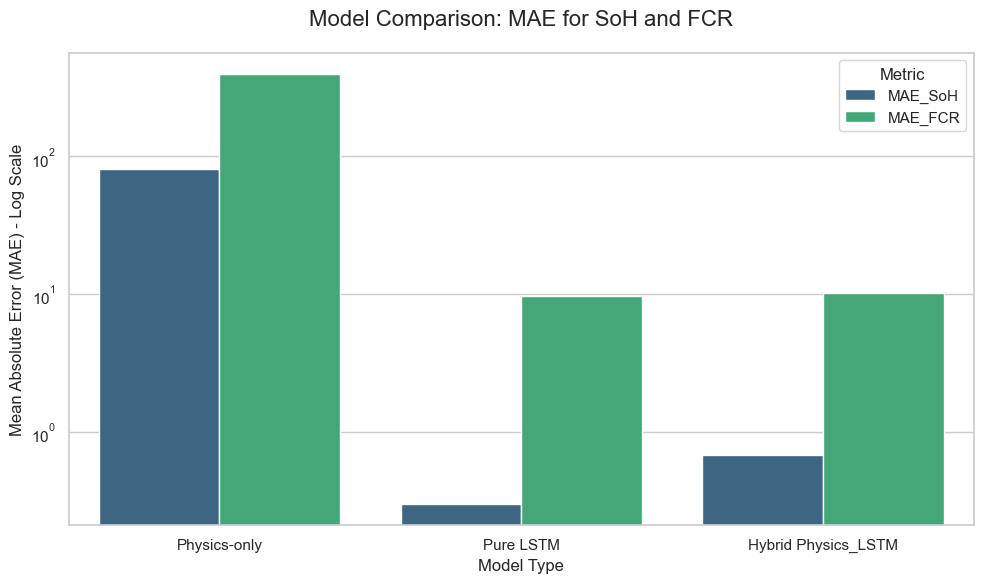

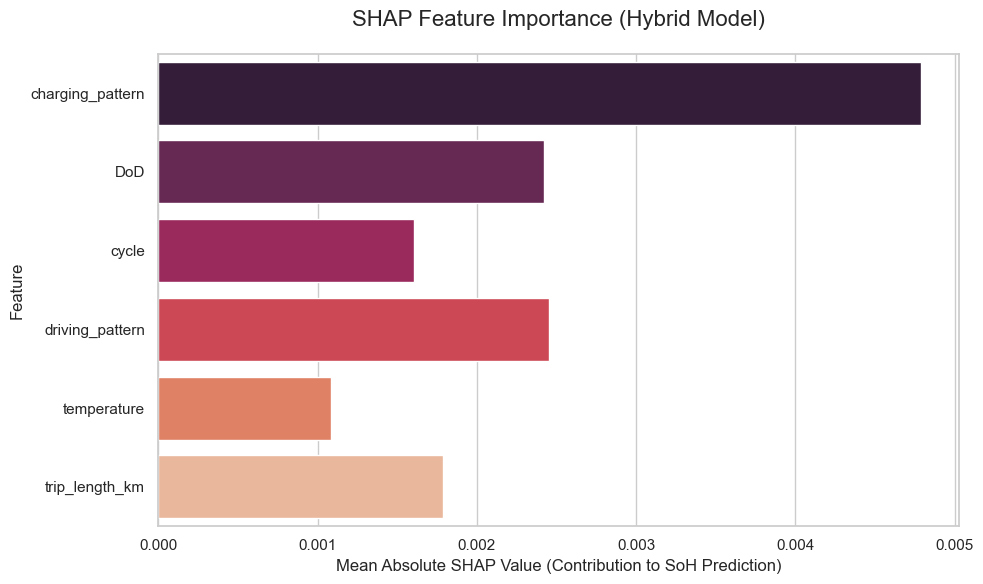

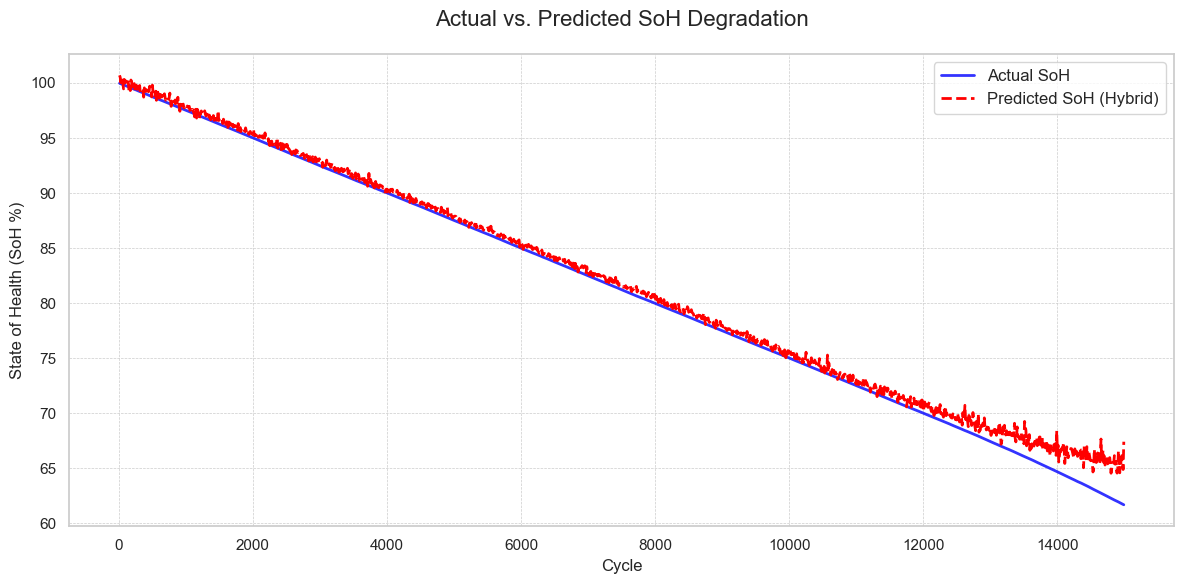

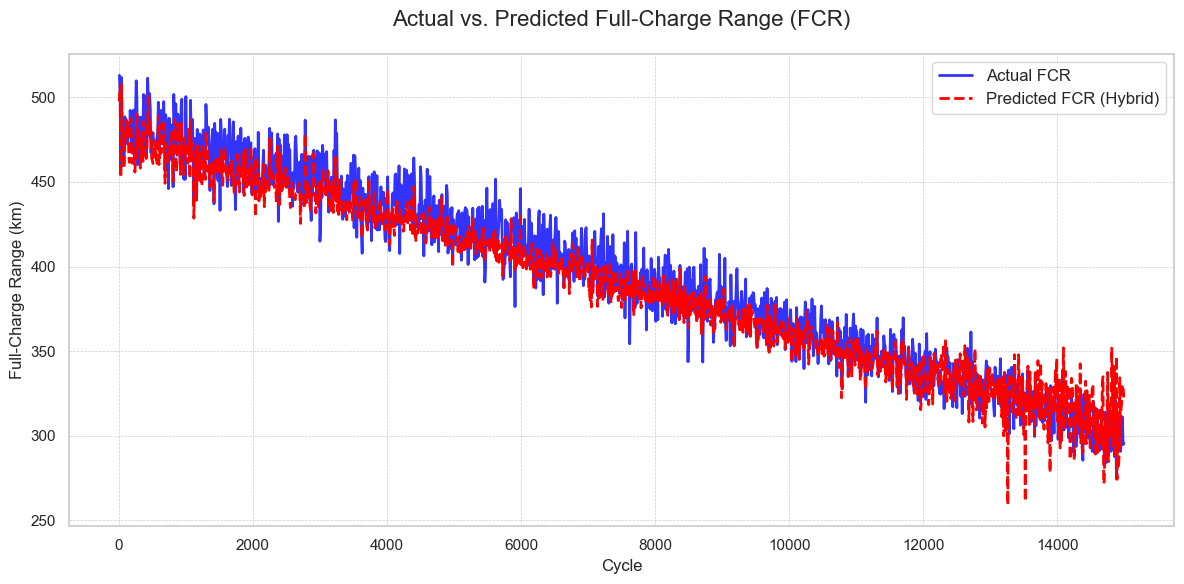

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore", category=UserWarning)
sns.set(style="whitegrid")


try:
    plot_df = pd.read_csv('plotting_data.csv')
    print("Loaded 'plotting_data.csv'")
except FileNotFoundError:
    print("Error: 'plotting_data.csv' not found.")
    print("Please run the main script first to generate this file.")
    exit()


comparison_data = {
    'Model': ['Physics-only', 'Pure LSTM', 'Hybrid Physics_LSTM'],
    'MAE_SoH': [80.678633, 0.300452, 0.678732],
    'MAE_FCR': [393.851525, 9.657224, 10.210389]
}
metrics_df_comparison = pd.DataFrame(comparison_data)


shap_data = {
    'Feature': ['charging_pattern', 'DoD', 'cycle', 'driving_pattern', 'temperature', 'trip_length_km'],
    'Importance (mean abs SHAP)': [0.004787, 0.002423, 0.001606, 0.002455, 0.001082, 0.001785]
}
shap_df = pd.DataFrame(shap_data)



print("Generating Plot 1: Model Comparison...")
metrics_melted = metrics_df_comparison.melt('Model', var_name='Metric', value_name='MAE')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=metrics_melted, x='Model', y='MAE', hue='Metric', palette='viridis')
plt.title('Model Comparison: MAE for SoH and FCR', fontsize=16, pad=20)
plt.ylabel('Mean Absolute Error (MAE) - Log Scale')
plt.xlabel('Model Type')
plt.yscale('log')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('1_model_comparison_barplot.png', dpi=300)



print("Generating Plot 2: Feature Importance...")
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_df, x='Importance (mean abs SHAP)', y='Feature', palette='rocket')
plt.title('SHAP Feature Importance (Hybrid Model)', fontsize=16, pad=20)
plt.xlabel('Mean Absolute SHAP Value (Contribution to SoH Prediction)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('2_shap_feature_importance.png', dpi=300)


print("Generating Plot 3: SoH Degradation...")
plot_df_sampled = plot_df.iloc[::10, :] 

plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_true'], label='Actual SoH', color='blue', alpha=0.8, linewidth=2)
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_pred'], label='Predicted SoH (Hybrid)', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted SoH Degradation', fontsize=16, pad=20)
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH %)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('3_soh_degradation_plot.png', dpi=300)


print("Generating Plot 4: FCR Prediction...")
plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_true'], label='Actual FCR', color='blue', alpha=0.8, linewidth=2)
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_pred'], label='Predicted FCR (Hybrid)', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Full-Charge Range (FCR)', fontsize=16, pad=20)
plt.xlabel('Cycle')
plt.ylabel('Full-Charge Range (km)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('4_fcr_prediction_plot.png', dpi=300)

print("All Visualizations Generated Successfully")